In [1]:
import torch
import torchvision
import time
import torch.nn.functional as F

from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchinfo import summary
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [2]:
#for nvidia 
has_gpu = torch.cuda.is_available()

device = "cuda" if torch.cuda.is_available() else "cpu"

device2 = "cuda" if torch.cuda.is_available() else "cpu"

print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print(f"Target device is {device} and {device2}")

random_seed = 1
batch_size = 128
num_epochs = 15
num_classes = 10

GPU is available
Target device is cuda and cuda


### Estimate Train Data Statistics Mean and Standard Deviation for Normalization

In [3]:
train_data_transform_example = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),

    #transforms.Resize((132, 132)),
    #transforms.RandomHorizontalFlip(0.5),
    #transforms.RandomCrop((128, 128)),
    #transforms.ToTensor(),
])

# Load your custom dataset
train_dataset = datasets.ImageFolder('dataset/train', transform=train_data_transform_example)

train_loader_example = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,  
    shuffle=False,
    num_workers=3,  
)

batch_mean_list = []
batch_std_list = []

# Calculate mean and std
for images, _ in train_loader_example:
    np_images = images.numpy()
    batch_mean = np.mean(np_images, axis=(0, 2, 3))
    batch_std = np.std(np_images, axis=(0, 2, 3))

    batch_mean_list.append(batch_mean)
    batch_std_list.append(batch_std)

# Average mean and std across all batches
train_mean = np.mean(batch_mean_list, axis=0)
train_std = np.mean(batch_std_list, axis=0)

print('Mean of all train images:', train_mean)
print('Std Dev of all train images:', train_std)


Mean of all train images: [0.6795612  0.68011266 0.6477788 ]
Std Dev of all train images: [0.34776595 0.34044668 0.36395618]


### Creating Data Transforms for Preprocessing Data

In [4]:
train_mean = [0.6795613, 0.68011266, 0.6477787]
train_std = [0.34776592, 0.34044662, 0.36395612]

# Training data transform with augmentation
train_data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)

    #transforms.Resize((132, 132)),
    #transforms.RandomHorizontalFlip(0.5),
    #transforms.RandomCrop((128, 128)),
    #transforms.ToTensor(),
    #transforms.Normalize(train_mean, train_std)

    #transforms.Resize((132, 132)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(15),
    #transforms.RandomCrop((128, 128)),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    #transforms.ToTensor(),
    #transforms.Normalize(train_mean, train_std)


    #transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(15),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    #transforms.ToTensor(),
    #transforms.Normalize(train_mean, train_std)
    
])

# Validation and Test data transform without augmentation
valid_test_data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)

    #transforms.Resize((224, 224)),
    #transforms.CenterCrop((128, 128)),
    #transforms.ToTensor(),
    #transforms.Normalize(train_mean, train_std)
    
    #transforms.Resize((132, 132)),
    #transforms.CenterCrop((128, 128)),
    #transforms.ToTensor(),
    #transforms.Normalize(train_mean, train_std)
    
])

### Loading Dataset

In [5]:
train_dataset = datasets.ImageFolder('dataset/train',transform=train_data_transform)
validation_dataset = datasets.ImageFolder('dataset/validation', transform=valid_test_data_transform)
test_dataset = datasets.ImageFolder('dataset/test', transform=valid_test_data_transform)

### Creating DataLoaders to get mini-batches

In [6]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    drop_last=True,  # Ensures consistent batch sizes during training
    num_workers=3, 
    shuffle=True  # shuffle the training data to prevent model from learning anything from the order of the samples
)

valid_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=batch_size,
    drop_last=False,  # Ensures all validation data is evaluated
    num_workers=3, 
    shuffle=False  # No need to shuffle validation data
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    drop_last=False,  # Ensures all test data is evaluated
    num_workers=3, 
    shuffle=False  # No need to shuffle test data
)

Mini_batch Dimensions: [B, C, H, W] = 
torch.Size([128, 3, 224, 224])
Labels = 
[[8 2 4 8 6 3 2 8]
 [3 9 4 2 7 0 5 0]
 [7 3 4 7 0 2 7 0]
 [0 7 1 8 1 2 5 7]
 [1 2 1 7 7 7 8 5]
 [8 6 7 5 5 1 9 4]
 [0 8 1 5 9 3 5 4]
 [4 3 0 1 0 6 7 1]]


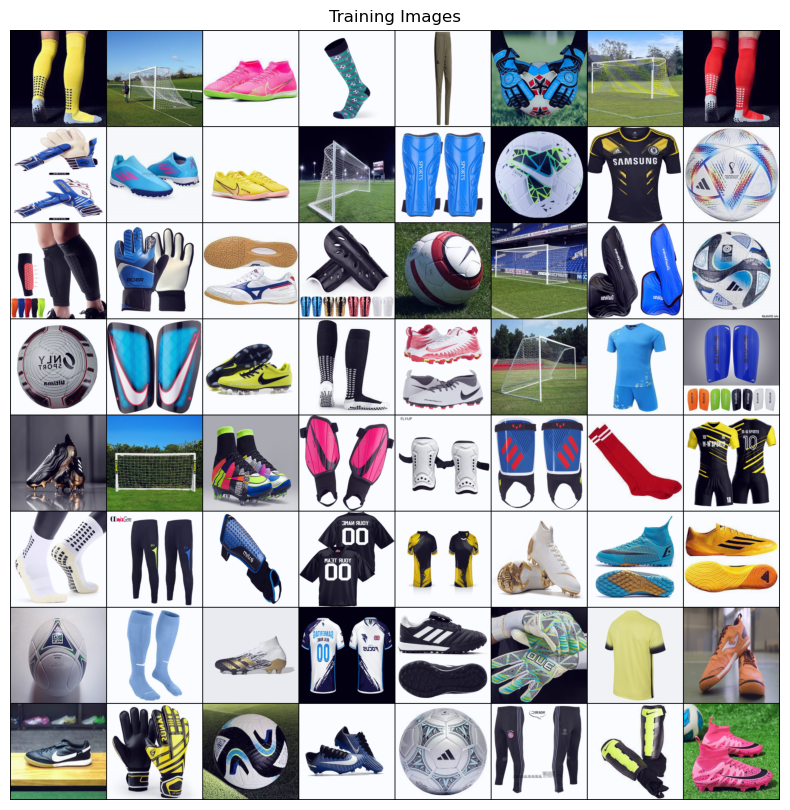

In [7]:
import torchvision.utils as vutils

%matplotlib inline

# Get a batch of training data
im_batch, labels_batch = next(iter(train_loader))

# Print mini-batch dimensions
print('Mini_batch Dimensions: [B, C, H, W] = ')
print(im_batch.shape)

# Visualize the training images
plt.figure(figsize=(10, 10))  # Increase figure size for better visibility
plt.title("Training Images")
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(im_batch[:64], nrow=8, padding=2, normalize=True).cpu(), (1, 2, 0)))

# Print the labels
print("Labels = ")
print(labels_batch[:64].data.numpy().reshape(8, -1)) 
plt.show()

### Loading ResNet50 Model

In [8]:
from torchvision.models import resnet50, ResNet50_Weights

# Load the pre-trained ResNet50 model with IMAGENET1K_V2 weights
model_extractor = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

model_ft = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Print the model to see its architecture
print(model_extractor)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### ResNet50 as a feature extractor and fine-tuned

In [9]:
# Freeze all layers in the network
for param in model_extractor.parameters():
    param.requires_grad = False

#model_extractor.fc = torch.nn.Sequential(
    #torch.nn.Linear(2048, 512),  # ResNet50's fc layer outputs 2048 features
    #torch.nn.ReLU(inplace=True),
    #torch.nn.Dropout(0.5),  # Optional: Dropout for regularization
    #torch.nn.Linear(512, num_classes),  # Output layer for 10 classes
#)

model_extractor.fc = torch.nn.Linear(2048, num_classes)


# Unfreeze all layers by not altering their requires_grad
# By default, it's set to True, so we don't need to explicitly change anything

# Replace the final layer
#model_ft.fc = torch.nn.Sequential(
    #torch.nn.Linear(2048, 512),
    #torch.nn.ReLU(inplace=True),
    #torch.nn.Dropout(0.5),
    #torch.nn.Linear(512, 10)  # Assuming num_classes=10
#)

model_ft.fc = torch.nn.Linear(2048, num_classes)


In [10]:
model_extractor = model_extractor.to(device)
model_extractor

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
mode_ft = model_ft.to(device2)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Helper function for Accuracy

In [12]:
def accuracy(model, data_loader, device):
    with torch.no_grad():
        true_pred = 0
        tot_samples = 0
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            _, label_pred = torch.max(logits, axis=1)
            true_pred += (label_pred==labels).sum()
            tot_samples += labels.shape[0]
        acc = (true_pred/float(tot_samples))*100
    return acc

### Feature Extractor Model Optimizer and Learning rate Scheduler Setup

In [13]:
torch.manual_seed(random_seed)
#applies a learning rate of 1e-2 to the parameters of the newly added layers
optimizer_extractor = torch.optim.Adam(model_extractor.fc.parameters(), lr=1e-2)

# Optionally, learning rate scheduler
scheduler_extractor = torch.optim.lr_scheduler.StepLR(optimizer_extractor, step_size=3, gamma=0.7)  


### Fine-Tuning Model Optimizer and Learning rate Scheduler Setup

In [14]:
torch.manual_seed(random_seed)
base_learning_rate = 1e-5
fc_learning_rate = 1e-2  #learning rate for the newly added layers


#Pre-trained layers (except for the last layer) are updated with a base learning rate of 1e-5


#The newly added sequential block (model_ft.fc) uses a higher learning rate of 1e-2 and includes a weight_decay for regularization.


#A StepLR learning rate scheduler is used to decay the learning rate by a factor of 0.5 every 3 

optimizer_ft = torch.optim.Adam([
    {'params': [param for name, param in model_ft.named_parameters() if 'fc' not in name], 'lr': base_learning_rate},
    {'params': model_ft.fc.parameters(), 'lr': fc_learning_rate, 'weight_decay': 0.5}
], lr=base_learning_rate)

scheduler_ft = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.5)


### Training

In [15]:
def train_model(model, optimizer, scheduler, num_epochs, device):
    start = time.time()
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        
        for batch_idx, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            
            # Forward pass
            logits = model(imgs)
            loss = F.cross_entropy(logits, labels)

            # Zero out the gradients, backpropagate, and update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
        # Average loss for this epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Adjust the learning rate based on the scheduler
        scheduler.step()
        
        # Evaluate on training and validation sets
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            train_accuracy = accuracy(model, train_loader, device)
            validation_accuracy = accuracy(model, valid_loader, device)
            valid_loss = sum(F.cross_entropy(model(xb.to(device)), yb.to(device)).item() for xb, yb in valid_loader) / len(valid_loader)
        
        train_accuracies.append(float(train_accuracy))  # Ensure it's a float
        valid_accuracies.append(float(validation_accuracy))  # Ensure it's a float
        valid_losses.append(valid_loss)

        print(f"Epoch {epoch+1} Complete: Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f} | Train Acc: {train_accuracy:.4f} | Validation Acc: {validation_accuracy:.4f}")
        print(f"Time Elapsed: {(time.time() - start) / 60:.2f} min")

    
    total_time = (time.time() - start) / 60
    print(f"Training completed in {total_time:.2f} min")
    
    # Plotting
    plot_training_results(train_losses, valid_losses, train_accuracies, valid_accuracies)


def plot_training_results(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, valid_losses, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, [float(acc) for acc in train_accuracies], 'bo-', label='Training accuracy')  # Explicit conversion if necessary
    plt.plot(epochs, [float(acc) for acc in valid_accuracies], 'ro-', label='Validation accuracy')  # Explicit conversion if necessary
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



Epoch 1 Complete: Train Loss: 1.4355 | Validation Loss: 0.7935 | Train Acc: 89.2188 | Validation Acc: 75.0000
Time Elapsed: 0.39 min
Epoch 2 Complete: Train Loss: 0.3216 | Validation Loss: 0.4797 | Train Acc: 95.3125 | Validation Acc: 82.0000
Time Elapsed: 0.77 min
Epoch 3 Complete: Train Loss: 0.1466 | Validation Loss: 0.3965 | Train Acc: 97.6562 | Validation Acc: 84.0000
Time Elapsed: 1.17 min
Epoch 4 Complete: Train Loss: 0.0945 | Validation Loss: 0.3644 | Train Acc: 99.2188 | Validation Acc: 86.0000
Time Elapsed: 1.57 min
Epoch 5 Complete: Train Loss: 0.0629 | Validation Loss: 0.3500 | Train Acc: 99.5312 | Validation Acc: 86.0000
Time Elapsed: 1.95 min
Epoch 6 Complete: Train Loss: 0.0492 | Validation Loss: 0.3361 | Train Acc: 99.8438 | Validation Acc: 85.0000
Time Elapsed: 2.33 min
Epoch 7 Complete: Train Loss: 0.0396 | Validation Loss: 0.3284 | Train Acc: 100.0000 | Validation Acc: 89.0000
Time Elapsed: 2.72 min
Epoch 8 Complete: Train Loss: 0.0326 | Validation Loss: 0.3222 | Tra

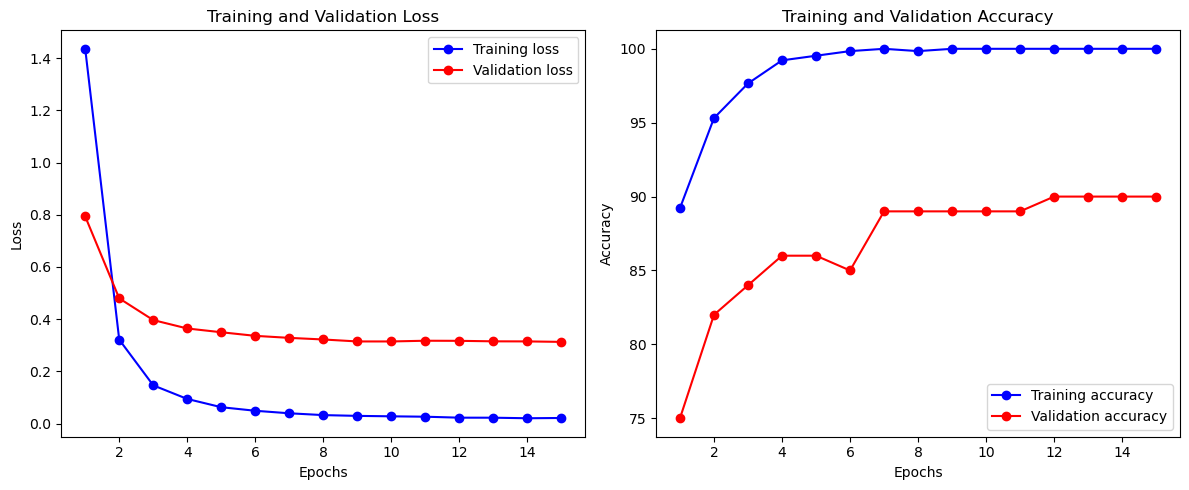

In [16]:
#call for the feature extractor model
train_model(model_extractor, optimizer_extractor, scheduler_extractor, num_epochs, device)

Epoch 1 Complete: Train Loss: 1.4759 | Validation Loss: 0.9323 | Train Acc: 84.0625 | Validation Acc: 76.0000
Time Elapsed: 2.11 min
Epoch 2 Complete: Train Loss: 0.7590 | Validation Loss: 0.8547 | Train Acc: 89.5312 | Validation Acc: 77.0000
Time Elapsed: 4.07 min
Epoch 3 Complete: Train Loss: 0.8175 | Validation Loss: 0.8180 | Train Acc: 90.4688 | Validation Acc: 84.0000
Time Elapsed: 6.06 min
Epoch 4 Complete: Train Loss: 0.6766 | Validation Loss: 0.7438 | Train Acc: 96.2500 | Validation Acc: 86.0000
Time Elapsed: 7.99 min
Epoch 5 Complete: Train Loss: 0.5954 | Validation Loss: 0.7030 | Train Acc: 95.3125 | Validation Acc: 84.0000
Time Elapsed: 10.02 min
Epoch 6 Complete: Train Loss: 0.5628 | Validation Loss: 0.6823 | Train Acc: 96.4062 | Validation Acc: 88.0000
Time Elapsed: 11.97 min
Epoch 7 Complete: Train Loss: 0.5438 | Validation Loss: 0.6860 | Train Acc: 96.7188 | Validation Acc: 86.0000
Time Elapsed: 13.93 min
Epoch 8 Complete: Train Loss: 0.5501 | Validation Loss: 0.6787 | T

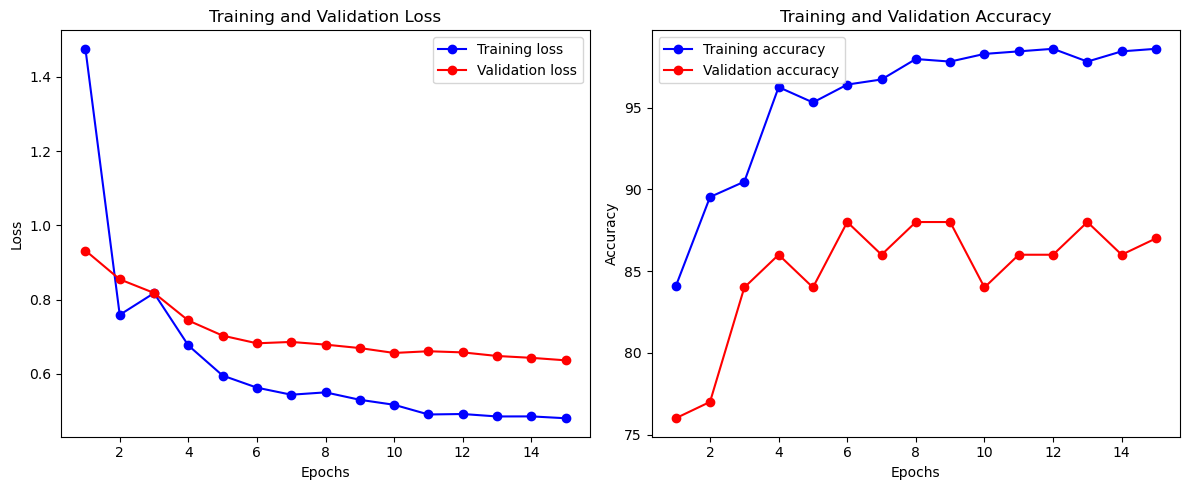

In [17]:
#call for the fine-tuning model
train_model(model_ft, optimizer_ft, scheduler_ft, num_epochs, device2)

In [18]:
test_acc = accuracy(model_extractor, test_loader, device)
print(f"Test Accuracy using extractor model: {test_acc:0.3f}")

Test Accuracy using extractor model: 92.000


In [19]:
test_acc = accuracy(model_ft, test_loader, device2)
print(f"Test Accuracy using fine-tuning model: {test_acc:0.3f}")

Test Accuracy using fine-tuning model: 91.500


### Confusion Matrix for Test Data using Feature Extractor Model

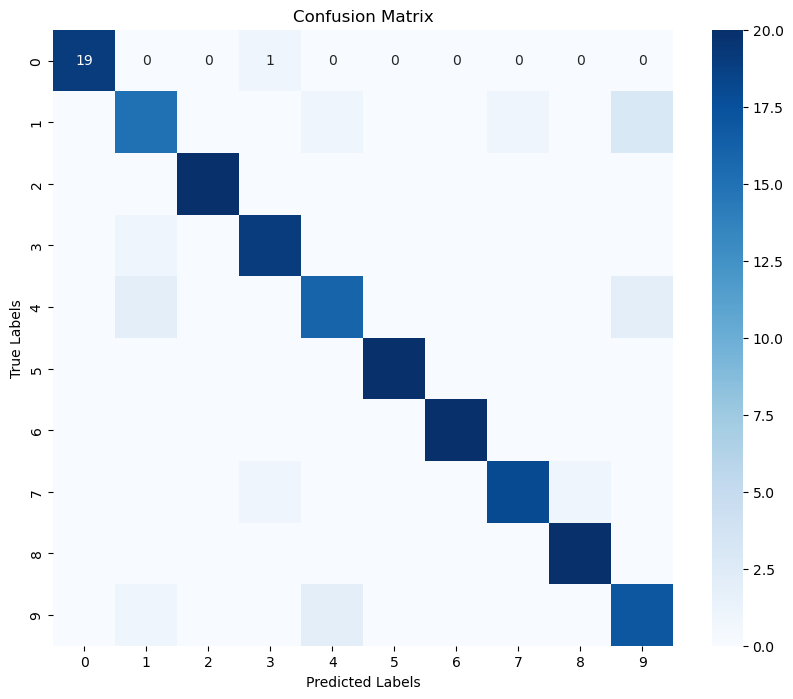

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect all predictions and true labels here
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        #move the images and labels to the gpu
        imgs = imgs.to(device)
        labels = labels.to(device)

        #perform the forward pass
        logits = model_extractor(imgs)

        #move logits to cpu for further numpy operations
        _, preds = torch.max(logits, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Confusion Matrix for Test Data using Fine-Tuned Model

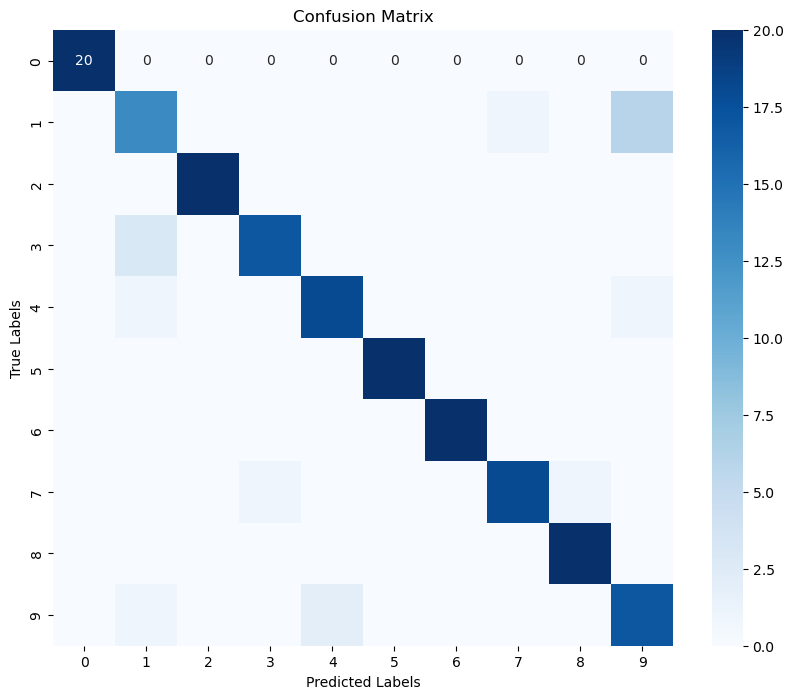

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect all predictions and true labels here
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        #move the images and labels to the gpu
        imgs = imgs.to(device2)
        labels = labels.to(device2)

        #perform the forward pass
        logits = model_ft(imgs)

        #move logits to cpu for further numpy operations
        _, preds = torch.max(logits, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()